In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from flifile import FliFile
import glob
import os
import skimage
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import timeit
from skimage.measure import LineModelND, ransac
import math
from sklearn.linear_model import RANSACRegressor, LinearRegression
from scipy.optimize import curve_fit

In [2]:
fli_1 = r'/home/preetham/Desktop/Project/Animations/50msEx3msGate_TRiCAM_4108628449.fli'
fli_2 = r'/home/preetham/Desktop/Project/Animations/50msEx5msGate_TRiCAM_4108628449.fli'

In [3]:
fli_1 = r'C:\Users\91748\OneDrive\Desktop\ANU FRT\The Project\Animations\50msEx3msGate_TRiCAM_4108628449.fli'
fli_2 = r'C:\Users\91748\OneDrive\Desktop\ANU FRT\The Project\Animations\50msEx5msGate_TRiCAM_4108628449.fli'

In [4]:
myfilefli_1 = FliFile(fli_1)
myfilefli_2 = FliFile(fli_2)
data_1 = myfilefli_1.getdata()
data_2 = myfilefli_2.getdata()
data = np.concatenate((data_1,data_2), axis =2)
print(type(data), np.shape(data)) 
#print(np.unravel_index(np.argmax(data), data.shape))
#print(data[1297,928])
print(np.mean(data))

<class 'numpy.ndarray'> (1920, 1200, 200)
2.254761488715278


104
(1920, 1200, 200)
(199,)


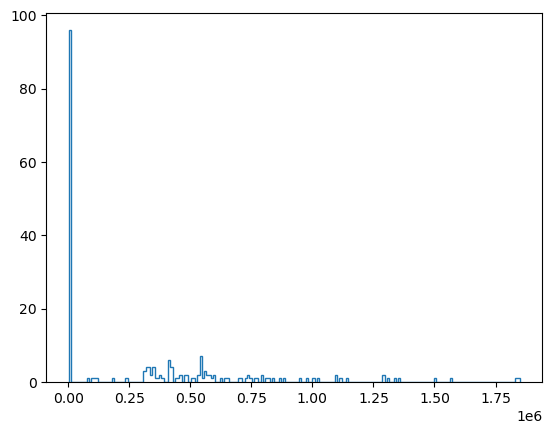

In [5]:
data_clear = np.where(data<15, 0, data)
clean_x = np.arange(0,99,1)
clean_y = np.array([(np.sum(data_clear[:,:,i])) for i in range(0,199)])
plt.hist(clean_y,bins = 200, histtype = 'step')
print(np.argmax(clean_y))
print(data_clear.shape)
print(clean_y.shape)

13
2194
248
(1920, 1200, 98)


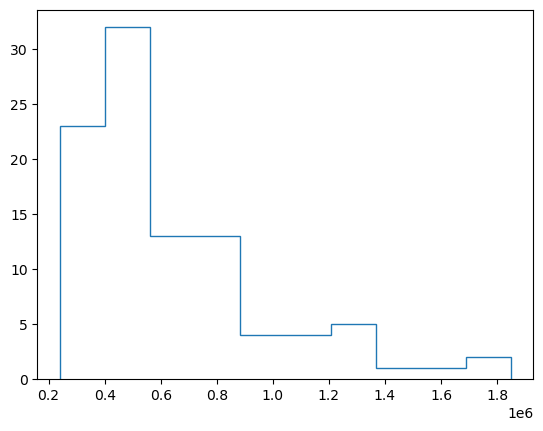

In [6]:
filter_y = np.argwhere(clean_y>200000).flatten()
#print(filter_x)
avl_data = np.array([data_clear[:,:,i] for i in filter_y])
avl_data = avl_data.transpose(1,2,0)
plt.hist(clean_y[filter_y], histtype ='step');
print(np.argmin(clean_y[filter_y]))
print(np.max(avl_data))
print(np.max(avl_data[:,:,26]))
print(avl_data.shape)
avl_data_sum = np.sum(avl_data, axis=2)

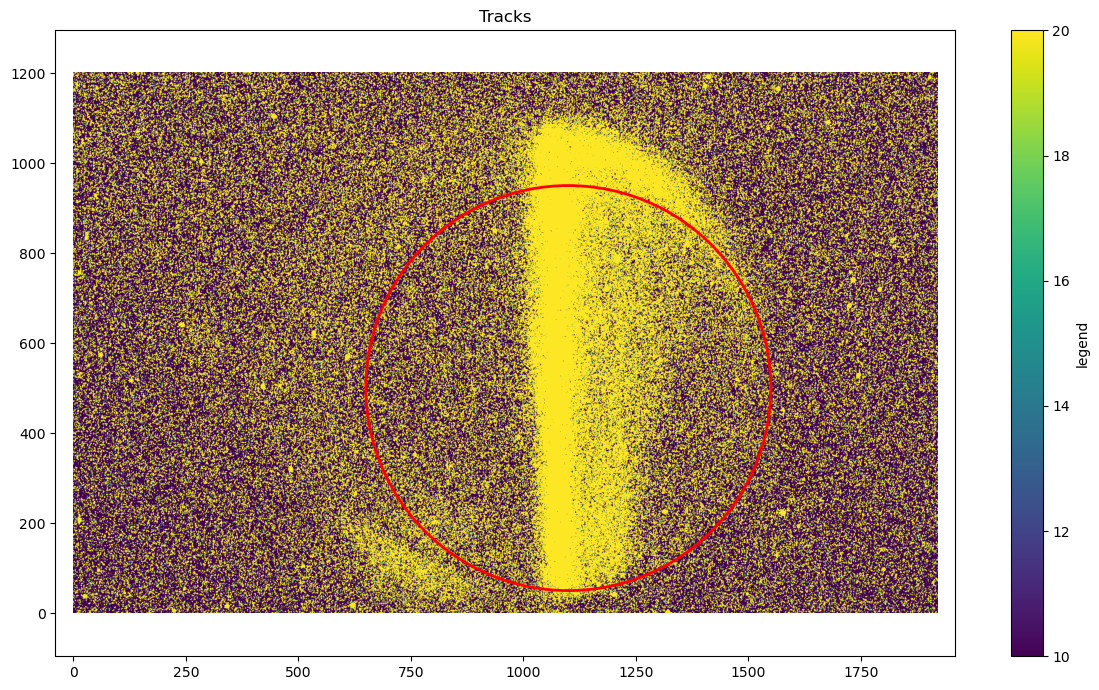

In [7]:
image = avl_data_sum.T
center_x, center_y, radius = 1100, 500, 450
plt.figure(figsize=(12,7))
im = plt.imshow(image, cmap='viridis', origin='lower', aspect='auto', vmin=10, vmax=20)
plt.colorbar(im, label='legend')
ax = plt.gca()
circ = plt.Circle((center_x, center_y), radius, color='red', fill=False, lw=2)
ax.add_patch(circ)
plt.axis('equal')
plt.title('Tracks')
plt.tight_layout()
plt.show()

That viewport looks fine'ish.

In [8]:
track_length_set_1 = np.array([])
angle_track_set_1 = np.array([])
energy_set_1 = np.array([])
sigma_set_1 = np.array([])
intensity_set_1 = np.array([])
int_1 = np.array([])

for i in range(0, 98):
    orig_image = avl_data[:, :, i].T
    masked_image = np.zeros_like(orig_image)

    # Create circular mask
    Y, X = np.ogrid[:orig_image.shape[0], :orig_image.shape[1]]
    dist_from_center = np.sqrt((X - center_x) ** 2 + (Y - center_y) ** 2)
    mask = dist_from_center <= radius

    # Apply mask
    masked_image[mask] = orig_image[mask]
    a = np.sum(masked_image)
    int_1 = np.append(int_1, a)

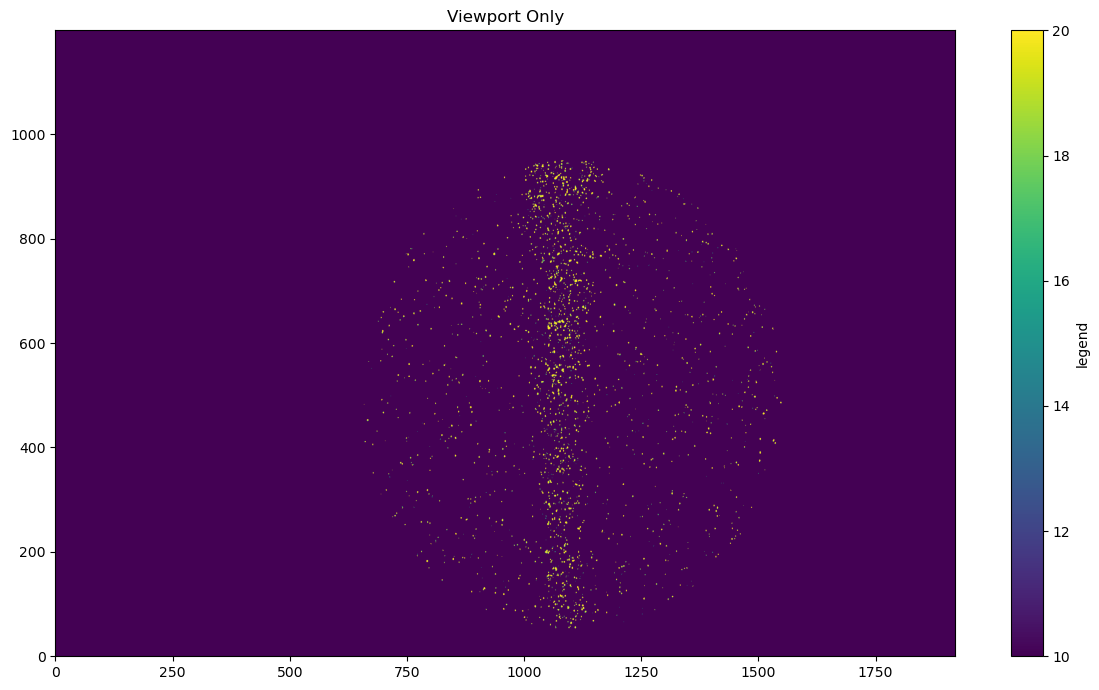

In [9]:
orig_image = avl_data[:,:,37].T
masked_image = np.zeros_like(orig_image)

# Create circular mask
Y, X = np.ogrid[:orig_image.shape[0], :orig_image.shape[1]]
dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
mask = dist_from_center <= radius

# Apply mask
masked_image[mask] = orig_image[mask]

# Plot to check
plt.figure(figsize=(12, 7))
plt.imshow(masked_image, cmap='viridis', origin='lower', aspect='auto', vmin=10, vmax=20)
plt.colorbar(label='legend')
plt.title('Viewport Only')
plt.tight_layout()
plt.show()

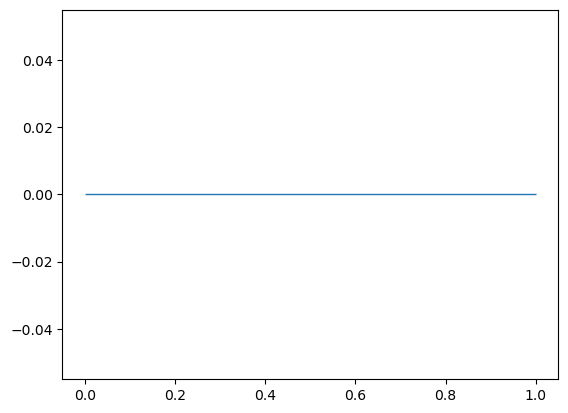

In [10]:
plt.hist(intensity_set_1, bins =100, histtype ='step');

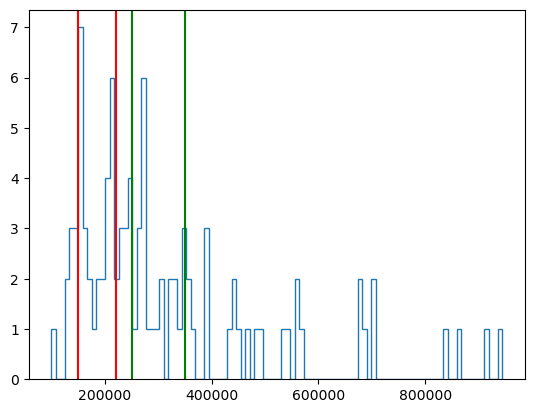

In [11]:
plt.hist(int_1, bins =100, histtype = 'step');
plt.axvline(0.15e6, color='r')
plt.axvline(0.22e6, color='r')
plt.axvline(0.25e6, color='g')
plt.axvline(0.35e6, color='g')

In [12]:
filtair = np.argwhere(int_1 > 0.15e6).flatten()
avl_data_ = np.array([avl_data[:,:,i] for i in filtair])
avl_data_ = avl_data
#avl_data_ = avl_data_.transpose(1,2,0)
print(avl_data_.shape)

(1920, 1200, 98)


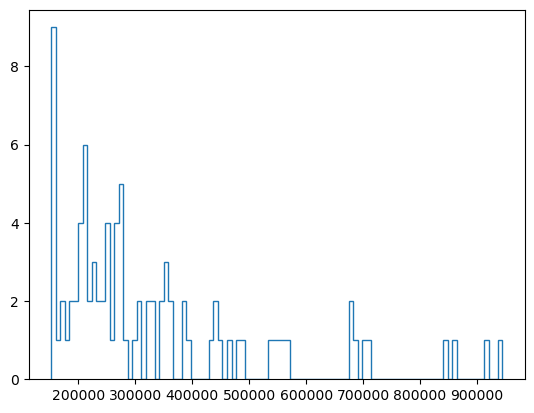

In [13]:
plt.hist(int_1[filtair], bins =100, histtype = 'step');

In [14]:
cut1 = (int_1>0)&(int_1<0.15e6)
cut2 = (int_1>0.15e6)&(int_1<0.23e6)
cut3 = (int_1>0.23e6)&(int_1<0.27e6)
cut4 = (int_1>0.27e6)&(int_1<0.45e6)
#cut5 = (int_1>0.35e6)&(int_1<0.45e6)
cut5 = (int_1>0.45e6)&(int_1<0.62e6)
cut6 = (int_1>0.62e6)&(int_1<0.9e6)
cut7 = int_1>0.9e6

In [15]:
print(sum(cut1))
print(sum(cut2))
print(sum(cut3), sum(cut4), sum(cut5), sum(cut6), sum(cut7))

9
32
12 27 9 7 2


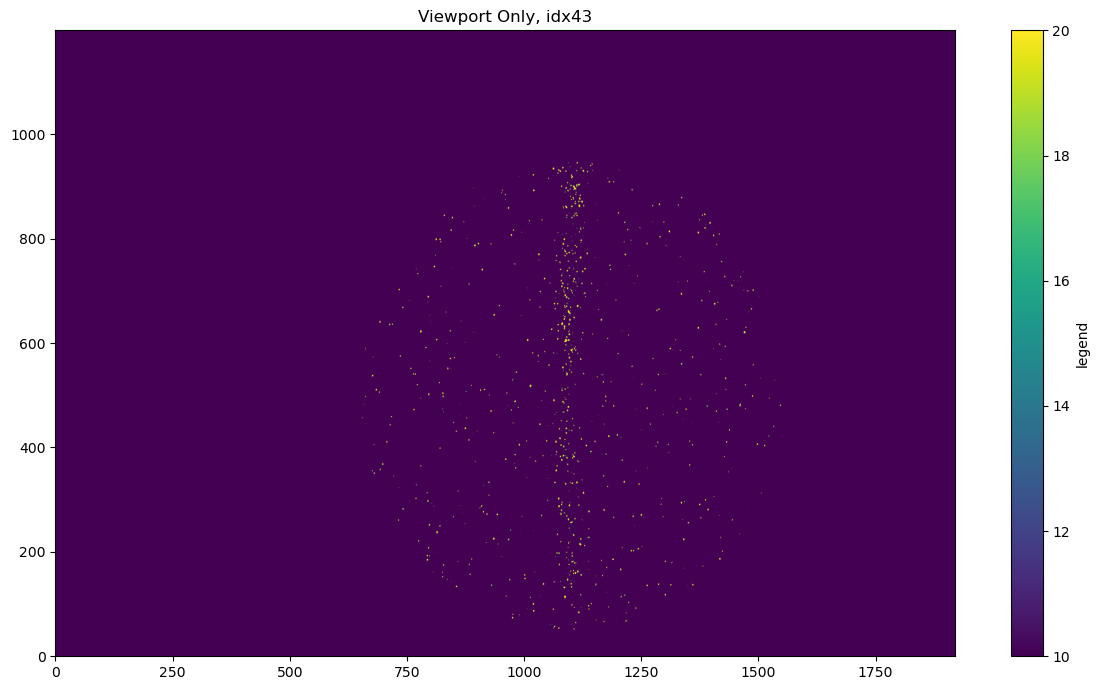

In [16]:
idx = np.random.choice(np.argwhere(cut1).flatten())

orig_image = avl_data_[:,:,idx].T
masked_image = np.zeros_like(orig_image)

# Create circular mask
Y, X = np.ogrid[:orig_image.shape[0], :orig_image.shape[1]]
dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
mask = dist_from_center <= radius

# Apply mask
masked_image[mask] = orig_image[mask]

# Plot to check
plt.figure(figsize=(12, 7))
plt.imshow(masked_image, cmap='viridis', origin='lower', aspect='auto', vmin=10, vmax=20)
plt.colorbar(label='legend')
plt.title(f'Viewport Only, idx{idx}')
plt.tight_layout()
plt.show()

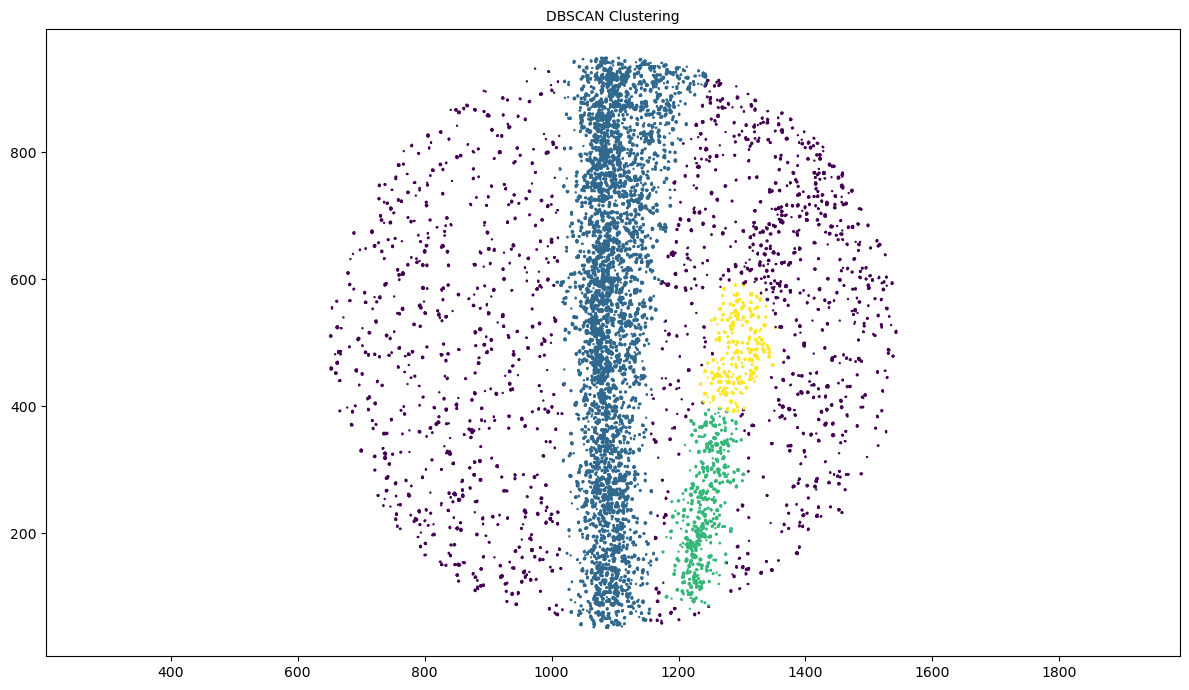

68
(19122, 2)


In [17]:
idx = np.random.choice(np.argwhere(cut7).flatten())

orig_image = avl_data_[:,:,idx].T
masked_image = np.zeros_like(orig_image)

# Create circular mask
Y, X = np.ogrid[:orig_image.shape[0], :orig_image.shape[1]]
dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
mask = dist_from_center <= radius

# Apply mask
masked_image[mask] = orig_image[mask]

# Plot to check
# plt.figure(figsize=(12, 7))
# plt.imshow(masked_image, cmap='viridis', origin='lower', aspect='auto', vmin=10, vmax=20)
# plt.colorbar(label='legend')
# plt.title(f'Viewport Only, idx{idx}')
# plt.tight_layout()
# plt.show()

#Binarise image
BinThr = 0
binary_image = np.where(masked_image>BinThr,1,0)

#Make coordinates
coords = np.nonzero(binary_image)
coords_array = np.column_stack(coords)

#DBSCAN CLUSTERING
cluster_size_array = np.zeros(4200)
count = 0
#time_start_dbscan = timeit.default_timer
db_eps = 29
db_min_samp = 200
dbscan  = DBSCAN(eps = db_eps, min_samples = db_min_samp)
dbscan.fit(coords_array)
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
if n_clusters_>0:
    clusters = [coords_array[labels == i] for i in range(n_clusters_)]
    clusters_size=[len(clusters[i]) for i in range(n_clusters_)]
    all_clusters= coords_array[labels!= -1]
    max_cluster=np.max(clusters_size) #how big is largest cluster
    cluster_size_array[count+1]=max_cluster
    ind=np.array(clusters[np.argmax(clusters_size)])  #indices of points in largest cluster
    if max_cluster > 1200:   #Threshold for track
        cluster_image = np.zeros_like(orig_image)
        fig=plt.figure(figsize=(12,7))
        plt.scatter(coords_array[:,1],coords_array[:,0],c=labels,s=0.5)
        plt.title('DBSCAN Clustering',fontsize=10)
        plt.xlim([0,1920])
        plt.ylim([0,1200])
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
print(idx)
print(np.shape(ind))

In [18]:
'''X = ind[:, 0].reshape(-1, 1)  # Feature: column index 1
y = ind[:, 1]                 # Target: column index 0

# Define RANSACRegressor with same parameters
ransac = RANSACRegressor(
    estimator=LinearRegression(),
    min_samples=10,
    residual_threshold=60,
    max_trials=1000,
    stop_score = 0.95
)

# Fit it
ransac.fit(X, y)

# Get inlier mask
inliers = ransac.inlier_mask_
outliers = ~inliers  # Logical NOT

print(len(y))
print(len(inliers))
# Plot same way
plt.figure(figsize=(12, 7))
plt.plot(y[inliers], X[inliers], '.b', alpha=0.6, label='Inlier data')
plt.plot(y[outliers], X[outliers], '.r', alpha=0.6, label='Outlier data')
plt.legend(loc='lower left')
plt.axis("equal")
plt.title('RANSAC (sklearn)')
plt.tight_layout()
plt.show()''';

RANSAC in general feels like a bad idea here

In [19]:
cuts_and_params = [
    ((int_1 > 0) & (int_1 < 0.15e6), {"eps": 70, "min_samples": 200}),
    ((int_1 > 0.15e6) & (int_1 < 0.23e6), {"eps": 55, "min_samples": 200}),
    ((int_1 > 0.23e6) & (int_1 < 0.27e6), {"eps": 50, "min_samples": 200}),
    ((int_1 > 0.27e6) & (int_1 < 0.45e6), {"eps": 45, "min_samples": 200}),
    ((int_1 > 0.45e6) & (int_1 < 0.62e6), {"eps": 37, "min_samples": 200}),
    ((int_1 > 0.62e6) & (int_1 < 0.9e6), {"eps": 29, "min_samples": 200}),
    ((int_1 > 0.9e6), {"eps": 29, "min_samples": 200}),
]


In [20]:
track_length_set_1 = np.zeros(98)
angle_track_set_1 = np.zeros(98)
energy_set_1 = np.zeros(98)
sigma_set_1 = np.zeros(98)
intensity_set_1 = np.zeros(98)
nct_int_set_1 = np.zeros(98)
track  = np.zeros((1920,1200,98))

for i in range(0, 98):
    orig_image = avl_data_[:, :, i].T
    masked_image = np.zeros_like(orig_image)

    # Create circular mask
    Y, X = np.ogrid[:orig_image.shape[0], :orig_image.shape[1]]
    dist_from_center = np.sqrt((X - center_x) ** 2 + (Y - center_y) ** 2)
    mask = dist_from_center <= radius

    # Apply mask
    masked_image[mask] = orig_image[mask]

    # Binarise image
    binary_image = np.where(masked_image > 0, 1, 0)

    # Make coordinates
    coords = np.nonzero(binary_image)
    coords_array = np.column_stack(coords)

    # DBSCAN CLUSTERING
    cluster_size_array = np.zeros(4200)
    count = 0
    for cut, params in cuts_and_params:
        if cut[i]:
            db_eps = params["eps"]
            db_min_samp = params["min_samples"]
            break
    dbscan = DBSCAN(eps=db_eps, min_samples=db_min_samp)
    dbscan.fit(coords_array)
    labels = dbscan.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    if n_clusters_ > 0:
        clusters = [coords_array[labels == i] for i in range(n_clusters_)]
        clusters_size = [len(clusters[i]) for i in range(n_clusters_)]
        all_clusters = coords_array[labels != -1]
        max_cluster = np.max(clusters_size)  # how big is largest cluster
        cluster_size_array[count + 1] = max_cluster
        ind = np.array(clusters[np.argmax(clusters_size)])  # indices of points in largest cluster

 # Use the entire largest cluster directly
        cluster_mask = np.zeros_like(orig_image)
        x = ind[:, 0]
        y = ind[:, 1]
        for j in range(len(x)):
            x_i = x[j]
            y_i = y[j]
            cluster_mask[x_i, y_i] = 1
        Track = masked_image * cluster_mask


        # PCA From here
        X = np.column_stack((x, y))
        pca = PCA(n_components=2)
        pca.fit(X)
        for length, vector in zip(pca.explained_variance_, pca.components_):
            v = vector * 2.5 * np.sqrt(length)
            start_point = pca.mean_ - v
            end_point = pca.mean_ + v

        # Building Component 1
        length = pca.explained_variance_[0]
        vector = pca.components_[0]
        v = vector * np.sqrt(length)

        mean = pca.mean_
        end_midpoint = mean + 0.5 * v
        start_midpoint = mean - 0.5 * v
        end_point = mean + 1 * v
        start_point = mean - 1 * v
        pca1_start_point = mean - 2.5 * v
        pca1_end_point = mean + 2.5 * v

        length_v_pca1 = int(np.linalg.norm(v))

        width_of_line = 15
        profile_pc1 = skimage.measure.profile_line(
            Track,
            pca1_end_point,
            pca1_start_point,
            linewidth=width_of_line,
            mode='constant',
            cval=0,
            reduce_func=np.sum
        )

        # Building Component 2
        length = pca.explained_variance_[1]
        vector = pca.components_[1]
        v = vector * 3 * np.sqrt(length)
        cut1_start = start_point - v
        cut1_end = start_point + v
        cut2_start = start_midpoint - v
        cut2_end = start_midpoint + v
        cut3_start = mean - v
        cut3_end = mean + v
        cut4_start = end_midpoint - v
        cut4_end = end_midpoint + v
        cut5_start = end_point - v
        cut5_end = end_point + v

        start = (cut3_start[0], cut3_end[0])
        end = (cut3_start[1], cut3_end[1])
        profile_pc2 = skimage.measure.profile_line(
            Track,
            cut3_start,
            cut3_end,
            linewidth=100,
            mode='constant',
            cval=0,
            reduce_func=np.sum
        )

        # Track length
        non_zero_elements = np.where(profile_pc1 > 0)
        first_non_zero_index = non_zero_elements[0][0]
        last_non_zero_index = non_zero_elements[0][-1]
        track_length_pixels = last_non_zero_index - first_non_zero_index
        track_length = track_length_pixels

        # Direction of Track
        direction_vector = pca.components_[0]
        # Clockwise from zero at source is negative, Anticlockwise is positive
        angle = -(90 - math.degrees(math.atan(direction_vector[0] / direction_vector[1])))
        if np.abs(angle) > 90:
            angle = 180 + angle

        track_length_set_1[i] = track_length
        angle_track_set_1[i] = angle

        #Energy and dE/dx
        Energy = np.sum(Track)
        de_dx = Energy/track_length
        energy_set_1[i] = de_dx
        intensity_set_1[i] = Energy

        #Sigma
        # Define the Gaussian function function to fit
        def gaussian(x, a, mu, sigma):
            return a*np.exp(-(x-mu)**2/(2*sigma**2))
                        
        #define data
        xdata=np.linspace(1,len(profile_pc2),num=len(profile_pc2)) 
        ydata=profile_pc2
    
        # fit the data and plot the result

        param, cov = curve_fit(gaussian, xdata,ydata, p0=(300,sum(xdata*ydata/sum(ydata)),5))
        amp_gaus  = param[0] #amplitude 
        mean_gaus = param[1] #mean of gaussian dist
        std_gaus = abs(param[2]) #stdev of the dist
        sigma= std_gaus
        sigma_set_1[i] = sigma

        #nct_intensity
        nct = np.count_nonzero(Track)
        nct_int_set_1[i] = nct

        #Adding track 
        track[:,:,i] = Track.T

762.0


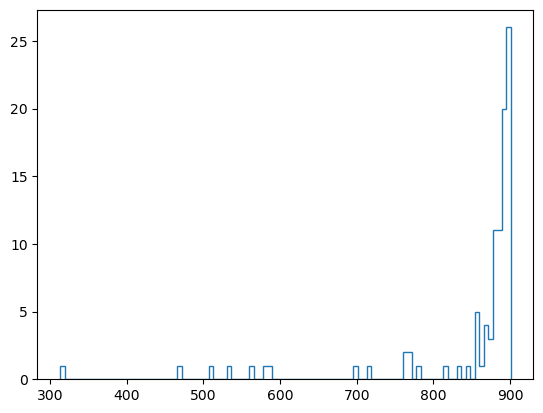

In [21]:
plt.hist(track_length_set_1, bins = 100, histtype = 'step');
filtair = np.argwhere((track_length_set_1>800)&(sigma_set_1<65)).flatten()
print(track_length_set_1[72])

37


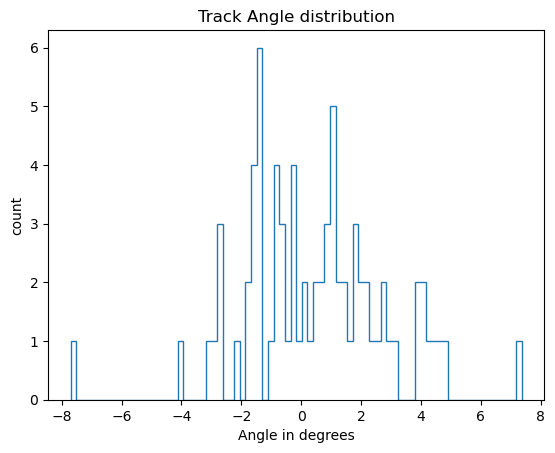

In [22]:
plt.hist(angle_track_set_1[filtair], bins = 80, histtype = 'step');
plt.xlabel('Angle in degrees')
plt.ylabel('count')
plt.title('Track Angle distribution')
plt.savefig('Track Angle distribution')
print(np.argmax(angle_track_set_1[filtair]))

76
16.96582798812106


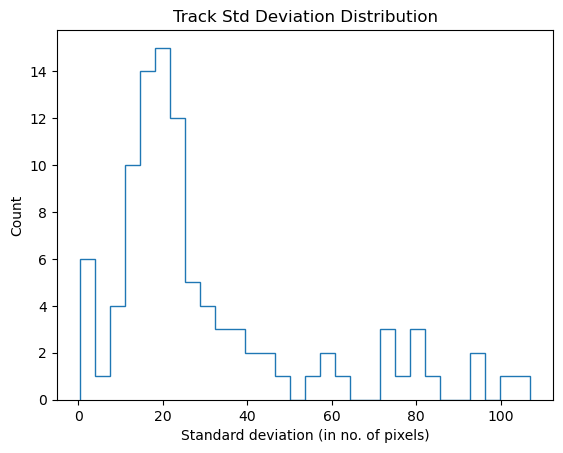

In [23]:
plt.hist(sigma_set_1, bins = 30, histtype = 'step');
plt.xlabel('Standard deviation (in no. of pixels)')
plt.ylabel('Count')
plt.title('Track Std Deviation Distribution')
plt.savefig('Track Std Deviation Distribution')
print(len(sigma_set_1[filtair]))
print(sigma_set_1[6])

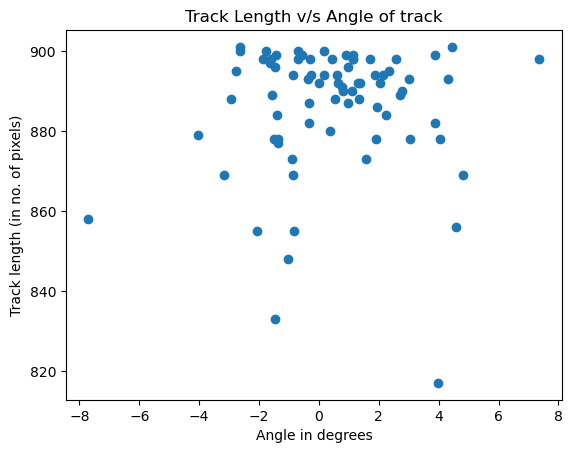

In [24]:
plt.scatter(angle_track_set_1[filtair], track_length_set_1[filtair])
plt.xlabel('Angle in degrees')
plt.ylabel('Track length (in no. of pixels)')
plt.title('Track Length v/s Angle of track')
plt.savefig('Track Length - Angle of track')

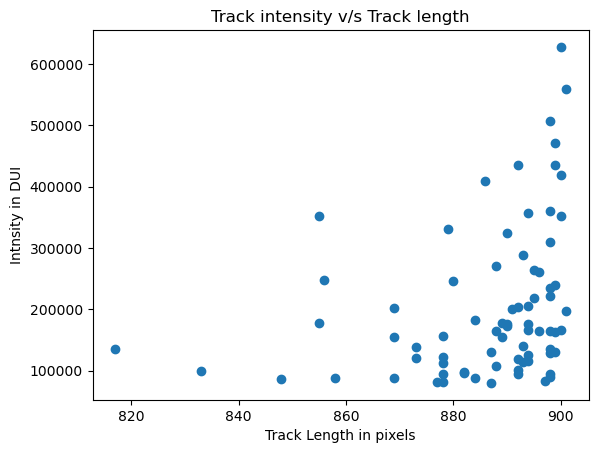

In [25]:
plt.scatter(track_length_set_1[filtair], intensity_set_1[filtair])
plt.title('Track intensity v/s Track length')
plt.xlabel('Track Length in pixels')
plt.ylabel('Intnsity in DUI')
plt.savefig('Track intensity - Track length')

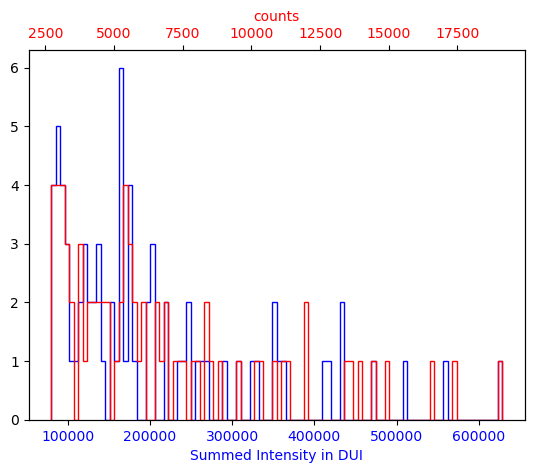

In [26]:
fig, ax1 = plt.subplots()

# First histogram (e.g., intensity)
ax1.hist(intensity_set_1[filtair], bins=100, histtype='step', color='blue', label='Intensity')
ax1.set_xlabel('Summed Intensity in DUI', color='blue')
ax1.tick_params(axis='x', labelcolor='blue')

# Twin x-axis
ax2 = ax1.twiny()
ax2.hist(nct_int_set_1[filtair], bins=100, histtype='step', color='red', label='Count Based Intensity')
ax2.set_xlabel('counts', color='red')
ax2.tick_params(axis='x', labelcolor='red')

#plt.title('Overlayed Histograms with Two X-Axes')
plt.savefig('Intensity Comparision.png')
plt.show()

## Sanity Check

In [27]:
pixel_size = 74.79*10**(-6)
sanity = np.mean(sigma_set_1[filtair])*pixel_size
sanity_2 = np.mean(track_length_set_1[filtair])*pixel_size
print('Std dev in microns',sanity*(10**(6)))
print('Average Track length in microns', sanity_2*(10**(6)))

Std dev in microns 1715.1575326677473
Average Track length in microns 66282.63750000001


In [28]:
1100*pixel_size

0.08226900000000001

68


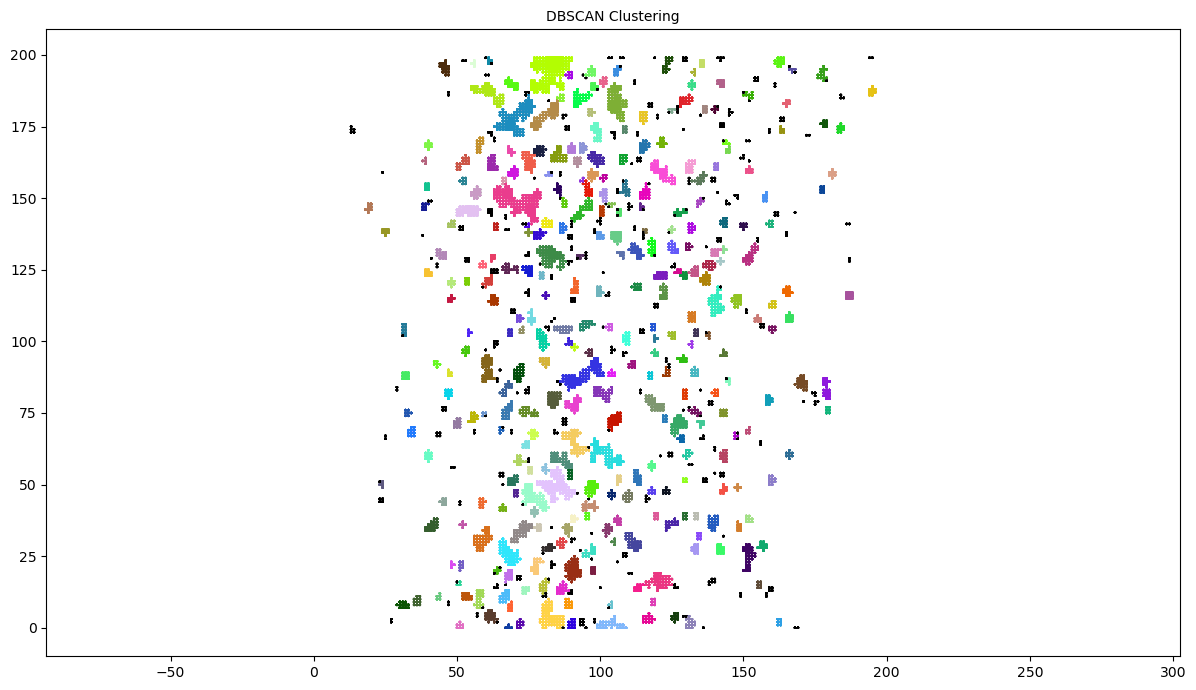

313
10144


In [37]:
idx = np.random.choice(np.argwhere(cut7).flatten())
print(idx)
BinThr = 0
image_ = track[1000:1200,600:800,idx].T
#binary_image = np.where(track[1000:1200,600:800,idx].T>BinThr,1,0)
#coords = np.nonzero(binary_image)
#coords_array = np.column_stack(coords)
#1000:1200,400:600,
#Make coordinates
coords = np.argwhere(image_>0)
intensities = image_[coords[:,0],coords[:,1]].astype(int)
repeats = np.repeat(coords, intensities, axis =0)
coords_array = repeats

#DBSCAN CLUSTERING
cluster_size_array = np.zeros(4200)
count = 0
#time_start_dbscan = timeit.default_timer
db_eps = 1
db_min_samp = 85
dbscan  = DBSCAN(eps = db_eps, min_samples = db_min_samp)
dbscan.fit(coords_array)
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
if n_clusters_>0:
    clusters = [coords_array[labels == i] for i in range(n_clusters_)]
    clusters_size=[len(clusters[i]) for i in range(n_clusters_)]
    all_clusters= coords_array[labels!= -1]
    max_cluster=np.max(clusters_size) #how big is largest cluster
    cluster_size_array[count+1]=max_cluster
    ind=np.array(clusters[np.argmax(clusters_size)])  #indices of points in largest cluster
    cluster_image = np.zeros_like(orig_image)
    fig=plt.figure(figsize=(12,7))
    cmap = plt.cm.nipy_spectral
    #plt.scatter(coords_array[:,1],coords_array[:,0],c=labels,cmap = cmap,s=0.5)
    unique_labels = set(labels)
    colors = {label: np.random.rand(3,) if label != -1 else (0, 0, 0) for label in unique_labels}  # Black for noise
    point_colors = np.array([colors[label] for label in labels])
    plt.scatter(coords_array[:,1], coords_array[:,0], c=point_colors, s=0.5)
    plt.title('DBSCAN Clustering',fontsize=10)
    plt.xlim([0,1920])
    plt.ylim([0,1200])
    plt.axis('equal')
    plt.tight_layout()
    #plt.savefig('Track Example cut 1 zoomed.png')
    plt.show()

print(n_clusters_)
print(max_cluster)
#print(coords_array)

In [30]:
int_1_ = int_1[filtair]

In [31]:
cats_and_pawrams = [
    ((int_1_ > 0) & (int_1_ < 0.15e6), {"eps": 1, "min_samples": 40}),
    ((int_1_ > 0.15e6) & (int_1_ < 0.23e6), {"eps": 1, "min_samples": 40}),
    ((int_1_ > 0.23e6) & (int_1_ < 0.27e6), {"eps": 1, "min_samples": 45}),
    ((int_1_ > 0.27e6) & (int_1_ < 0.45e6), {"eps": 1, "min_samples": 55}),
    ((int_1_ > 0.45e6) & (int_1_ < 0.62e6), {"eps": 1, "min_samples": 65}),
    ((int_1_ > 0.62e6) & (int_1_ < 0.9e6), {"eps": 1, "min_samples": 75}),
    ((int_1_ > 0.9e6), {"eps": 1, "min_samples": 85}),
]

In [32]:
elec_count = np.zeros(76)
track_ = track[:,:,filtair]
for i in range(0,76):
    BinThr = 0
    image_ = track_[:,:,i].T
    #1000:1200,400:600,
    #Make coordinates
    coords = np.argwhere(image_>0)
    intensities = image_[coords[:,0],coords[:,1]].astype(int)
    repeats = np.repeat(coords, intensities, axis =0)
    coords_array = repeats
    #DBSCAN CLUSTERING
    cluster_size_array = np.zeros(4200)
    count = 0
    #time_start_dbscan = timeit.default_timer
    for cut, params in cats_and_pawrams:
        if cut[i]:
            db_eps = params["eps"]
            db_min_samp = params["min_samples"]
            break
    dbscan  = DBSCAN(eps = db_eps, min_samples = db_min_samp)
    dbscan.fit(coords_array)
    labels = dbscan.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    elec_count[i] = n_clusters_


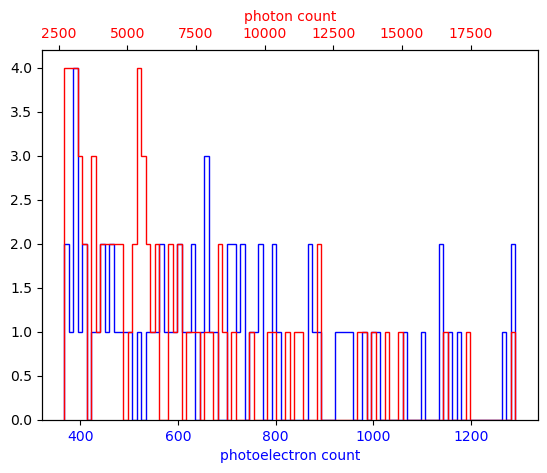

In [33]:
fig, ax1 = plt.subplots()

# First histogram (e.g., intensity)
ax1.hist(elec_count, bins=100, histtype='step', color='blue', label='Intensity')
ax1.set_xlabel('photoelectron count', color='blue')
ax1.tick_params(axis='x', labelcolor='blue')

# Twin x-axis
ax2 = ax1.twiny()
ax2.hist(nct_int_set_1[filtair], bins=100, histtype='step', color='red', label='Count Based Intensity')
ax2.set_xlabel('photon count', color='red')
ax2.tick_params(axis='x', labelcolor='red')

#plt.title('Overlayed Histograms with Two X-Axes')
plt.savefig('photoelectron count1.png')
plt.show()

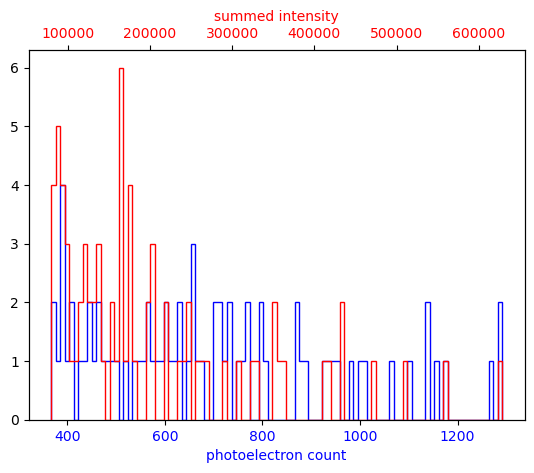

In [34]:
fig, ax1 = plt.subplots()

# First histogram (e.g., intensity)
ax1.hist(elec_count, bins=100, histtype='step', color='blue', label='Intensity')
ax1.set_xlabel('photoelectron count', color='blue')
ax1.tick_params(axis='x', labelcolor='blue')

# Twin x-axis
ax2 = ax1.twiny()
ax2.hist(intensity_set_1[filtair], bins=100, histtype='step', color='red', label='Count Based Intensity')
ax2.set_xlabel('summed intensity', color='red')
ax2.tick_params(axis='x', labelcolor='red')

#plt.title('Overlayed Histograms with Two X-Axes')
plt.savefig('photoelectron count2.png')
plt.show()